<h1 align='center' style='color:purple'><b>Grid Search CV</b></h1>

GridSearchCV is an Exhaustive search over specified parameter values for an estimator (ML Model). Model's performance for Each combination of defined hyper-parameters are calculated along with Cross Validation. In this way, using GridSearchCV you can find the best combination of hyper-parameters for a model.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

<b> Upload Data </b>

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

In [2]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

<b> Outlier Removal</b>

Find and remove Outliers from the Dataset

Using Box Plot, Detect the outliers of each features in our dataset. Any point above or below the whiskers represent an outlier. 

Text(0.5, 1.0, 'Boxplot of all Features')

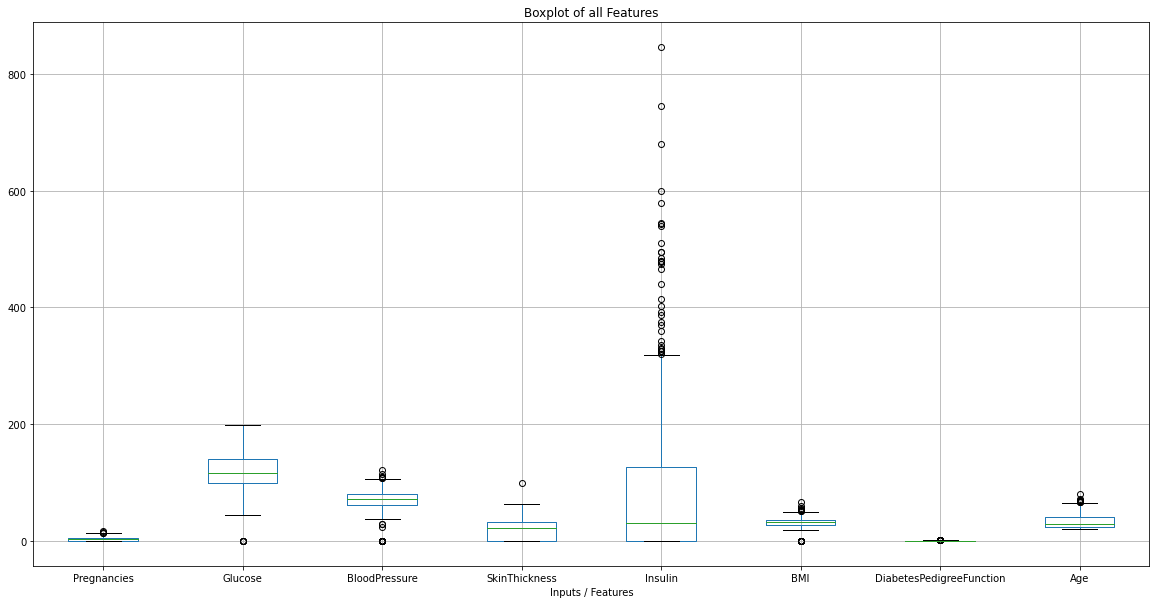

In [3]:
plt.figure(figsize = (20,10))
df.drop('Outcome', axis = 1).boxplot()
plt.xlabel('Inputs / Features')
plt.title('Boxplot of all Features')

In [4]:
# Store the length of Initial Dataset
number_of_records = df.shape[0]

# For every input/ Feature, identify and remove outliers
for i in df.columns.drop('Outcome'):

    # Find 1st and 3rd Quartile
    q1 = df[i].quantile(0.25)
    q3 = df[i].quantile(0.75)

    # Find Inter Quartile Range (IQR)
    iqr = q3-q1

    # Find lower and Upper Limits
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr

    # Remove Outliers (Data Points/Records Present outside (lower_limit, upper_limit) Range)
    df = df[(df[i] > lower_limit) & (df[i] < upper_limit)]
    

<b> Find out How many outliers were identified and removed by finding the difference in the lengeth of Dataset Before and After Outlier Removal </b>

In [5]:
print('{} Outliers removed.'.format(number_of_records-len(df)))

132 Outliers removed.


<b> Separate Inputs and Target </b>

In [6]:
inputs = df.drop('Outcome',axis='columns')
target = df.Outcome

## Approach 1: Use train_test_split and manually tune parameters by trial and error

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(inputs,target,test_size=0.3)

In [8]:
# Here we are using a Support Vector Classifier
from sklearn import svm
model = svm.SVC(kernel='rbf',C=30,gamma='auto')
model.fit(X_train,y_train)
print('Model Accuracy :', round(model.score(X_test, y_test),3))

Model Accuracy : 0.738


## Approach 2: Use K Fold Cross validation

**Manually try suppling models with different parameters to cross_val_score function with 5 fold cross validation**

In [9]:
from sklearn.model_selection import cross_val_score

In [10]:
cross_val_score(svm.SVC(kernel='linear',C=10,gamma='auto'), inputs, target, cv=5)

array([0.765625  , 0.72440945, 0.75590551, 0.81889764, 0.80314961])

In [11]:
cross_val_score(svm.SVC(kernel='rbf',C=10,gamma='auto'),inputs, target, cv=5)

array([0.6875    , 0.68503937, 0.68503937, 0.69291339, 0.69291339])

In [12]:
cross_val_score(svm.SVC(kernel='rbf',C=20,gamma='auto'),inputs, target, cv=5)

array([0.6875    , 0.68503937, 0.68503937, 0.69291339, 0.69291339])

**Above approach is tiresome and very manual. We can use for loop as an alternative**

In [13]:
kernels = ['rbf', 'linear']
C = [1,10,20]
avg_scores = {}
for kval in kernels:
    for cval in C:
        cv_scores = cross_val_score(svm.SVC(kernel=kval,C=cval,gamma='auto'),inputs, target, cv=5)
        avg_scores[kval + '_' + str(cval)] = np.average(cv_scores)

avg_scores

{'rbf_1': 0.6886811023622048,
 'rbf_10': 0.6886811023622048,
 'rbf_20': 0.6886811023622048,
 'linear_1': 0.7767347440944882,
 'linear_10': 0.7735974409448818,
 'linear_20': 0.7814714566929133}

From above results we can say that rbf with C=10,20 or linear with C=20 will give best performance

## Approach 3: Use [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

Parameters :
 - estimator : estimator/Model object.
 - param_grid : Dictionary with parameters names (str) as keys and lists of parameter settings.
 - scoring : string representing the Strategy to evaluate the performance of the cross-validated model on the test set.
 - n_jobs : integer representing the Number of jobs to run in parallel. None means 1 and -1 means using all processors.
 - cv : integer to define how many fold cross validation needs to be performed.

**GridSearchCV does exactly same thing as for loop above but in a single line of code**

In [14]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Initialize GridSearchCV
clf = GridSearchCV(svm.SVC(gamma='auto'), {
    'C': [1,10,20],
    'kernel': ['rbf','linear']
}, cv=5, return_train_score=False)

# Fit / Train GridSearchCV
clf.fit(inputs, target)

# Print Cross-validation Results
clf.cv_results_

{'mean_fit_time': array([4.16834354e-02, 1.89493122e+00, 1.87436581e-02, 1.85691559e+01,
        1.73464298e-02, 2.83667678e+01]),
 'std_fit_time': array([2.64187840e-03, 4.67823897e-01, 4.11725916e-04, 2.33106271e+00,
        7.94294613e-04, 6.77813264e+00]),
 'mean_score_time': array([0.00897474, 0.0020051 , 0.00439434, 0.0021945 , 0.00399575,
        0.00240602]),
 'std_score_time': array([6.30300473e-04, 6.47377051e-04, 7.94739134e-04, 7.46964847e-04,
        1.38279487e-05, 8.05465765e-04]),
 'param_C': masked_array(data=[1, 1, 10, 10, 20, 20],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['rbf', 'linear', 'rbf', 'linear', 'rbf', 'linear'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1, 'kernel': 'rbf'},
  {'C': 1, 'kernel': 'linear'},
  {'C': 10, 'kernel': 'rbf'},
  {'C': 10, 'kernel': 'li

In [15]:
# Store the GridSearchCV Results in a DataFrame
df2 = pd.DataFrame(clf.cv_results_)
df2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.041683,0.002642,0.008975,0.000630,1,rbf,"{'C': 1, 'kernel': 'rbf'}",0.687500,0.685039,0.685039,0.692913,0.692913,0.688681,0.003571,4
1,1.894931,0.467824,0.002005,0.000647,1,linear,"{'C': 1, 'kernel': 'linear'}",0.773438,0.740157,0.763780,0.803150,0.803150,0.776735,0.024133,2
2,0.018744,0.000412,0.004394,0.000795,10,rbf,"{'C': 10, 'kernel': 'rbf'}",0.687500,0.685039,0.685039,0.692913,0.692913,0.688681,0.003571,4
3,18.569156,2.331063,0.002194,0.000747,10,linear,"{'C': 10, 'kernel': 'linear'}",0.765625,0.724409,0.755906,0.818898,0.803150,0.773597,0.033827,3
4,0.017346,0.000794,0.003996,0.000014,20,rbf,"{'C': 20, 'kernel': 'rbf'}",0.687500,0.685039,0.685039,0.692913,0.692913,0.688681,0.003571,4
5,28.366768,6.778133,0.002406,0.000805,20,linear,"{'C': 20, 'kernel': 'linear'}",0.765625,0.740157,0.771654,0.811024,0.818898,0.781471,0.029422,1


In [16]:
# Check the Model SCore For different values of C and Kernel used
df2[['param_C','param_kernel','mean_test_score']]

,param_C,param_kernel,mean_test_score
0,1,rbf,0.688681
1,1,linear,0.776735
2,10,rbf,0.688681
3,10,linear,0.773597
4,20,rbf,0.688681
5,20,linear,0.781471


In [17]:
print('Best Model Parameters : ',clf.best_params_)

Best Model Parameters :  {'C': 20, 'kernel': 'linear'}


In [18]:
print('Best Score :', round(clf.best_score_,3))

Best Score : 0.781


<b>Use RandomizedSearchCV to reduce number of iterations and with random combination of parameters. This is useful when you have too many parameters to try and your training time is longer. It helps reduce the cost of computation Time.</b>

In [19]:
from sklearn.model_selection import RandomizedSearchCV
rs = RandomizedSearchCV(svm.SVC(gamma='auto'), {
        'C': [1,10,20],
        'kernel': ['rbf','linear']
    }, 
    cv=5, 
    return_train_score=False, 
    n_iter=2
)
rs.fit(inputs, target)
pd.DataFrame(rs.cv_results_)[['param_C','param_kernel','mean_test_score']]

,param_C,param_kernel,mean_test_score
0,10,rbf,0.688681
1,1,linear,0.776735


**How about different models with different hyperparameters?**

In [20]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Dictionary consisting of 3 Models (SVM, RandomForest & Logistic Regression) and their Hyper-parameter list
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10]
        }
    }
}

In [21]:
# Initialize a list to Store Model name, best score and best parameters
scores = []

# Import Models & their parameters from the dictionary
for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(inputs, target)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
  
# Make a Dataframe of the scores list with proper columns names
df3 = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df3

,model,best_score,best_params
0,svm,0.781471,"{'C': 20, 'kernel': 'linear'}"
1,random_forest,0.781447,{'n_estimators': 10}
2,logistic_regression,0.783046,{'C': 5}


<b> In this way you, can perform Hyper-parameter tuning on multiple models at the same time.</b>